# Transfer function of parallel formant resonator

In [17]:
import numpy as np
import math
import matplotlib.pyplot as plt

# amplitude response
def amp_res(A,B,C,omega_Hz,array,formant, t_s):
    '''
    input: 
    A, B, C: list, 3 coefficients
    omega_Hz: float, angular frequency, = 2*pi*frequency
    array: array, to store result
    formant: int, formant number, 1-2 
    t_s: float, sampling period Ts
    
    output: int, amplitude values in linear scale for every frequency
    '''
    assert type(array) == np.ndarray
    for i in range(5000):
        amp = A[formant]/math.sqrt(math.pow((1-C[formant])*math.cos(omega_Hz[i]*t_s)-B[formant],2)+math.pow((1+C[formant])*math.sin(omega_Hz[i]*t_s),2))
        array[0][i] = amp
    return array
        
# phase response
def phase_res(A,B,C,omega_Hz,array,formant, t_s):
    '''
    input: 
    A, B, C: list, 3 coefficients
    omega_Hz: float, angular frequency, = 2*pi*frequency
    array: array, to store result
    formant: int, formant number, 1-3
    t_s: float, sampling period Ts
    
    output: int, phase values in radians for every frequency
    '''
    assert type(array) == np.ndarray
    for i in range(5000):
        pha = -math.atan2((1+C[formant])*math.sin(omega_Hz[i]*t_s),(1-C[formant])*math.cos(omega_Hz[i]*t_s)-B[formant])
        array[0][i] = pha
    return array

def lp_amp(A,B,C,omega_Hz,array,formant, t_s):
    '''
    input: 
    A, B, C: list, 3 coefficients
    omega_Hz: float, angular frequency, = 2*pi*frequency
    array: array, to store result
    formant: int, formant number, 1-5 
    t_s: float, sampling period Ts
    
    output: int, amplitude values in dB for every frequency
    '''
    assert type(array) == np.ndarray
    for i in range(5000):
        amp = A[formant]/math.sqrt(1+math.pow(B[formant],2)-2*B[formant]*math.cos(omega_Hz[i]*t_s))
        array[0][i] = amp
    return array

def lp_pha(A,B,C,omega_Hz,array,formant, t_s):
    '''
    input: 
    A, B, C: list, 3 coefficients
    omega_Hz: float, angular frequency, = 2*pi*frequency
    array: array, to store result
    formant: int, formant number, 1-5 
    t_s: float, sampling period Ts
    
    output: int, phase values in degree for every frequency
    '''
    assert type(array) == np.ndarray
    for i in range(5000):
        pha = -math.atan2(B[formant]*math.sin(omega_Hz[i]*t_s),1-B[formant]*math.cos(omega_Hz[i]*t_s))
        array[0][i] = pha
        return array


#frequency response
def frequency_response(name, gain, f_n, b_n):
    '''
    input: 
    name: str, vowel name
    gain: list, amplitude control for each formant
    f_n: list, cutoff frequency (F)
    b_n: list, bandwidth (BW)
    
    output: 
    amplitude response graph, phase response graph, amplitude response array, phase response array
    '''
    assert type(f_n) == type(b_n) == type(gain) == list
    f_step = 1                      #int, frequency step
    f_s = 10000                     #int, sampling frequency (Fs): 10 kHz
    f_Hz = np.arange(0,5000,f_step) #array, frequency range(0Hz,5000Hz), with frequency step 1 Hz, altogether 5000 samples
    omega_Hz = 2*math.pi*f_Hz       #array, angular frequency = 2*pi*f
    t_s = 1/f_s                     #float, sampling period (Ts) = 1/sampling frequency = 0.1 ms
    
    #compute sigma & omega
    sigma, omega = [], []
    for i in range(len(f_n)):
        sigma.append(-np.pi*b_n[i]) #σ = -pi*BW
        omega.append(2*np.pi*f_n[i])#ω = 2*pi*F
    
    #compute A,B,C
    A, B, C = [], [], []
    for i in range(len(f_n)):
        C.append(-math.exp(2*sigma[i]*t_s))                     #C = -exp(-2*pi*BW*Ts) = -exp(2*σ*Ts)
        B.append(2*math.exp(sigma[i]*t_s)*np.cos(omega[i]*t_s)) #B = 2*exp(-pi*BW*Ts)*cos(2*pi*F*Ts) = 2*exp(σ*Ts)*cos(ω*Ts)
        A.append(1-B[i]-C[i])                                   #A = 1- B - C
        
    # first order low-pass filter               
    B.append(math.exp(-2*math.pi*100*t_s)) 
    A.append(1-B[3])
    
    
    #create arrays for storing amplitude response of 2 formants
    amp_1 = np.empty([1,5000],dtype = float)
    amp_2 = np.empty([1,5000],dtype = float)
    amp_3 = np.empty([1,5000],dtype = float)
    
    #compute amplitude response of 2 formants, adjust amplitude for each formant
    amp_1 = gain[0] * amp_res(A,B,C,omega_Hz,amp_1, 0, t_s) 
    amp_2 = gain[1] * amp_res(A,B,C,omega_Hz,amp_2, 1, t_s) 
    amp_3 = gain[2] * amp_res(A,B,C,omega_Hz,amp_3, 2, t_s) 
    
    #create arrays for storing phase response of 2 formants
    pha_1 = np.empty([1,5000],dtype = float)
    pha_2 = np.empty([1,5000],dtype = float)
    pha_3 = np.empty([1,5000],dtype = float)
    
    #compute phase response of 3 formants
    pha_1 = phase_res(A,B,C,omega_Hz,pha_1, 0, t_s) 
    pha_2 = phase_res(A,B,C,omega_Hz,pha_2, 1, t_s) 
    pha_3 = phase_res(A,B,C,omega_Hz,pha_3, 2, t_s) 

    
    
    # frequency response 
    
    #add up 3 sets of amplitude response (subtract the second resonator due to polarity reversal)
    amp_sum = np.empty([1,5000],dtype = float)
    for i in range(5000):
        result = math.sqrt((amp_1[0][i]**2) + (amp_2[0][i]**2) + (amp_3[0][i]**2)
                           - 2*amp_1[0][i]*amp_2[0][i]*math.cos(pha_1[0][i]-pha_2[0][i])
                           + 2*amp_1[0][i]*amp_3[0][i]*math.cos(pha_1[0][i]-pha_3[0][i])
                           - 2*amp_2[0][i]*amp_3[0][i]*math.cos(pha_2[0][i]-pha_3[0][i]))
        amp_sum[0][i] = 20*np.log10(result)  # convert to dB scale
    
    
    # phase response
        
    #sum up 3 sets of phase response
    pha_sum = np.empty([1,5000],dtype = float)
    for i in range(5000):
        #result = math.atan2(amp_1[0][i]*math.sin(pha_1[0][i]) + amp_2[0][i]*math.sin(pha_2[0][i]) + amp_3[0][i]*math.sin(pha_3[0][i]), 
                            #amp_1[0][i]*math.cos(pha_1[0][i]) + amp_2[0][i]*math.cos(pha_2[0][i]) + amp_3[0][i]*math.cos(pha_3[0][i]))
        result = math.atan2(amp_1[0][i]*math.sin(pha_1[0][i]) - amp_2[0][i]*math.sin(pha_2[0][i]) + amp_3[0][i]*math.sin(pha_3[0][i]), 
                            amp_1[0][i]*math.cos(pha_1[0][i]) - amp_2[0][i]*math.cos(pha_2[0][i]) + amp_3[0][i]*math.cos(pha_3[0][i]))
        pha_sum[0][i] = np.degrees(result)   # convert to degree scale
    pha_sum[0] = np.unwrap(pha_sum[0])

    #plot amplitude response and save the graph
    #plt.figure("Amplitude response")
    #plt.xlabel('frequency (Hz)')
    #plt.ylabel('amplitude (dB)')
    #plt.plot(f_Hz,amp_sum[0])
    #plt.title("Amplitude response - " + str(name))
    #plt.savefig('parallel_amplitude_'+str(name)+'.jpg')
    
    #plot phase response and save the graph
    #plt.figure("Phase response")
    #plt.xlabel('frequency (Hz)')
    #plt.ylabel('phase (degree)')
    #plt.plot(f_Hz,pha_sum[0])
    #plt.title("Phase response - " + str(name))
    #plt.savefig('parallel_phase_'+str(name)+'.jpg')
    #plt.show()
    
    return amp_sum, pha_sum

## Compared to cascade model 

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt

#amplitude response
def cas_amp_res(A,B,C,omega_Hz,array,formant, t_s):
    '''
    input: 
    A, B, C: list, 3 coefficients
    omega_Hz: float, angular frequency, = 2*pi*frequency
    array: array, to store result
    formant: int, formant number, 1-5 
    t_s: float, sampling period Ts
    
    output: int, amplitude values in dB for every frequency
    '''
    assert type(array) == np.ndarray
    for i in range(5000):
        amp = A[formant]/math.sqrt(math.pow((1-C[formant])*math.cos(omega_Hz[i]*t_s)-B[formant],2)+math.pow((1+C[formant])*math.sin(omega_Hz[i]*t_s),2))
        array[0][i] = 20*np.log10(amp)
    return array
        
#phase response
def cas_phase_res(A,B,C,omega_Hz,array,formant, t_s):
    '''
    input: 
    A, B, C: list, 3 coefficients
    omega_Hz: float, angular frequency, = 2*pi*frequency
    array: array, to store result
    formant: int, formant number, 1-5 
    t_s: float, sampling period Ts
    
    output: int, phase values in degree for every frequency
    '''
    assert type(array) == np.ndarray
    for i in range(5000):
        pha = -math.atan2((1+C[formant])*math.sin(omega_Hz[i]*t_s),(1-C[formant])*math.cos(omega_Hz[i]*t_s)-B[formant])
        array[0][i] = (180*pha)/math.pi 
    return array

def cas_lp_amp(A,B,C,omega_Hz,array,formant, t_s):
    '''
    input: 
    A, B, C: list, 3 coefficients
    omega_Hz: float, angular frequency, = 2*pi*frequency
    array: array, to store result
    formant: int, formant number, 1-5 
    t_s: float, sampling period Ts
    
    output: int, amplitude values in dB for every frequency
    '''
    assert type(array) == np.ndarray
    for i in range(5000):
        amp = A[formant]/math.sqrt(1+math.pow(B[formant],2)-2*B[formant]*math.cos(omega_Hz[i]*t_s))
        array[0][i] = 20*np.log10(amp)
    return array

def cas_lp_pha(A,B,C,omega_Hz,array,formant, t_s):
    '''
    input: 
    A, B, C: list, 3 coefficients
    omega_Hz: float, angular frequency, = 2*pi*frequency
    array: array, to store result
    formant: int, formant number, 1-5 
    t_s: float, sampling period Ts
    
    output: int, phase values in degree for every frequency
    '''
    assert type(array) == np.ndarray
    for i in range(5000):
        pha = -math.atan2(B[formant]*math.sin(omega_Hz[i]*t_s),1-B[formant]*math.cos(omega_Hz[i]*t_s))
        array[0][i] = (180*pha)/math.pi 
    return array

#frequency response
def cascade_frequency_response(name,f_n,b_n):
    '''
    input: 
    name: str, vowel name
    f_n: list, cutoff frequency (F)
    b_n: list, bandwidth (BW)
    
    output: 
    amplitude response graph, phase response graph, amplitude response array, phase response array
    '''
    assert type(f_n) == type(b_n) == list
    f_step = 1                      #int, frequency step
    f_s = 10000                     #int, sampling frequency (Fs): 10 kHz
    f_Hz = np.arange(0,5000,f_step) #array, frequency range(0Hz,5000Hz), with frequency step 1 Hz, altogether 5000 samples
    omega_Hz = 2*math.pi*f_Hz       #array, angular frequency = 2*pi*f
    t_s = 1/f_s                     #float, sampling period (Ts) = 1/sampling frequency = 0.1 ms = 0.0001 s
    
    #compute sigma & omega
    sigma, omega = [], []
    for i in range(5):
        sigma.append(-np.pi*b_n[i]) #σ = -pi*BW
        omega.append(2*np.pi*f_n[i])#ω = 2*pi*F
    
    #compute A,B,C
    A, B, C = [], [], []
    for i in range(5):
        C.append(-math.exp(2*sigma[i]*t_s))                     #C = -exp(-2*pi*BW*Ts) = -exp(2*σ*Ts)
        B.append(2*math.exp(sigma[i]*t_s)*np.cos(omega[i]*t_s)) #B = 2*exp(-pi*BW*Ts)*cos(2*pi*F*Ts) = 2*exp(σ*Ts)*cos(ω*Ts)
        A.append(1-B[i]-C[i])                                   #A = 1- B - C

    # first order low-pass filter               
    B.append(math.exp(-2*math.pi*100*t_s)) 
    A.append(1-B[5])
    
    #create arrays for storing amplitude response of 5 formants
    amp_1 = np.empty([1,5000],dtype = float)
    amp_2 = np.empty([1,5000],dtype = float)
    amp_3 = np.empty([1,5000],dtype = float)
    amp_4 = np.empty([1,5000],dtype = float)
    amp_5 = np.empty([1,5000],dtype = float)
    
    #compute amplitude response of 5 formants
    cas_amp_res(A,B,C,omega_Hz,amp_1, 0, t_s)
    cas_amp_res(A,B,C,omega_Hz,amp_2, 1, t_s)
    cas_amp_res(A,B,C,omega_Hz,amp_3, 2, t_s)
    cas_amp_res(A,B,C,omega_Hz,amp_4, 3, t_s)
    cas_amp_res(A,B,C,omega_Hz,amp_5, 4, t_s)
    
    #sum up 5 sets of amplitude response
    amp_sum = np.empty([1,5000],dtype = float)
    for i in range(5000):
        amp_sum[0][i] = amp_1[0][i]+amp_2[0][i]+amp_3[0][i]+amp_4[0][i]+amp_5[0][i]
    
    plt.figure('individual formant for amplitude')
    plt.plot(f_Hz, amp_1[0], label='F1')
    plt.plot(f_Hz, amp_2[0], label='F2')
    plt.plot(f_Hz, amp_3[0], label='F3')
    plt.xlabel('frequency (Hz)')
    plt.ylabel('amplitude (dB)')
    plt.legend()
    plt.title('Amplitude spectrum of three resonators')
    


    #plot amplitude response and save the graph
    #plt.figure("Amplitude response")
    #plt.xlabel('frequency (Hz)')
    #plt.ylabel('amplitude (dB)')
    #plt.plot(f_Hz,amp_sum[0])
    #plt.title("Amplitude response - "+ str(name))
    #plt.ylim([-30,25])
    #plt.savefig('cascade_amplitude_' + str(name)+'.jpg')
    
    
    #create arrays for storing phase response of 5 formants
    pha_1 = np.empty([1,5000],dtype = float)
    pha_2 = np.empty([1,5000],dtype = float)
    pha_3 = np.empty([1,5000],dtype = float)
    pha_4 = np.empty([1,5000],dtype = float)
    pha_5 = np.empty([1,5000],dtype = float)

    
    #compute phase response of 5 formants
    cas_phase_res(A,B,C,omega_Hz,pha_1, 0, t_s)
    cas_phase_res(A,B,C,omega_Hz,pha_2, 1, t_s)
    cas_phase_res(A,B,C,omega_Hz,pha_3, 2, t_s)
    cas_phase_res(A,B,C,omega_Hz,pha_4, 3, t_s)
    cas_phase_res(A,B,C,omega_Hz,pha_5, 4, t_s)
    
    plt.figure('individual formant for phase')
    plt.plot(f_Hz, pha_1[0], label='F1')
    plt.plot(f_Hz, pha_2[0], label='F2')
    plt.plot(f_Hz, pha_3[0], label='F3')
    plt.xlabel('frequency (Hz)')
    plt.ylabel('phase (degree)')
    plt.legend()
    plt.title('Phase spectrum of three resonators')
    
    #sum up 5 sets of phase response
    pha_sum = np.empty([1,5000],dtype = float)
    for i in range(5000):
        pha_sum[0][i] = pha_1[0][i]+pha_2[0][i]+pha_3[0][i]+pha_4[0][i]+pha_5[0][i]
       
    pha_sum_3 = np.empty([1,5000],dtype = float)
    for i in range(5000):
        pha_sum_3[0][i] = pha_1[0][i]+pha_2[0][i]+pha_3[0][i]
    #plot phase response and save the graph
    #plt.figure("Phase response")
    #plt.xlabel('frequency (Hz)')
    #plt.ylabel('phase (degree)')
    #plt.plot(f_Hz,pha_sum[0])
    #plt.title("Phase response - "+str(name))
    #plt.savefig('cascade_phase_'+str(name)+'.jpg')
    #plt.show()
    
    return amp_sum, pha_sum, pha_sum_3
    

amplitudes of the three formant frequencies (parallel): 17.37 dB 6.69 dB 12.59 dB
unity gain of parallel model: 2.14
amplitudes of the five formant frequencies (cascade)(dB)": 17.39380303450248 6.679728589245559 12.726939259059504 16.760687487204375 9.711220183366855
unity gain of cascade model: 0.0


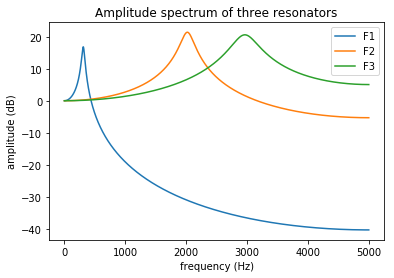

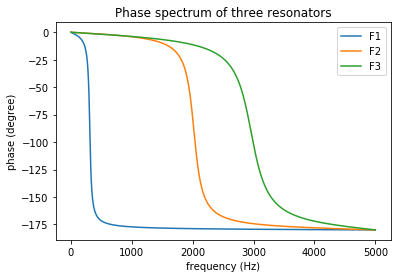

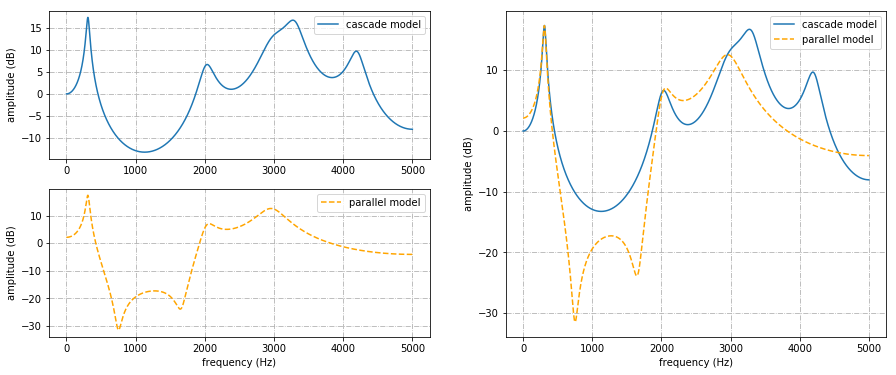

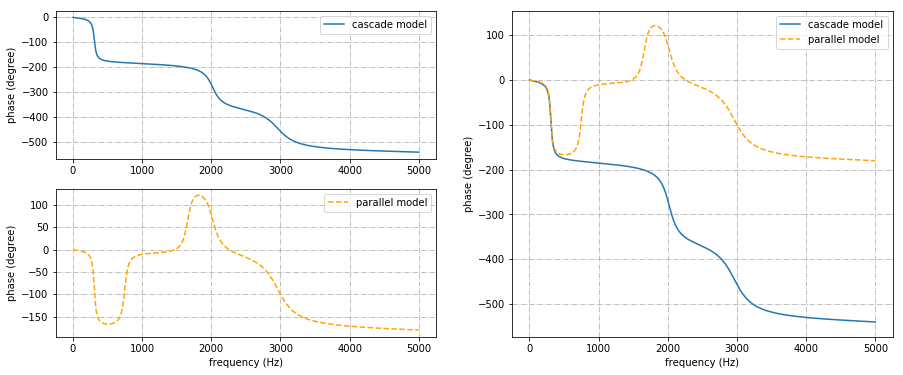

In [23]:
#i
# parallel model
f_i = [310,2020,2960]  # cutoff frequency  310 2020
b_i = [45,200,400]    # bandwidth 45 200 400
gain = [1.06,0.18,0.4]  # amplitude control 1.3 0.2 0.4
(amp_i,pha_i) = frequency_response('i',gain, f_i,b_i)

#find maximal amplitude
F1_i = round(max(amp_i[0][100:1000]),2)
F2_i = round(max(amp_i[0][1000:2030]),2)
F3_i = round(max(amp_i[0][2030:2961]),2)
print('amplitudes of the three formant frequencies (parallel):',F1_i, 'dB', F2_i, 'dB', F3_i, 'dB')
print('unity gain of parallel model:', round(amp_i[0][0],2))

# cascade model
cas_f_i = [310,2020,2960,3300,4200]
cas_b_i = [45,200,400,250,200]
(cas_amp_i,cas_pha_i, cas_pha_i_3) = cascade_frequency_response('i',cas_f_i,cas_b_i)

#find maximal amplitude
F1_i = max(cas_amp_i[0][100:1000]) 
F2_i = max(cas_amp_i[0][1000:2030])
F3_i = max(cas_amp_i[0][2030:2961])
F4_i = max(cas_amp_i[0][3000:4000])
F5_i = max(cas_amp_i[0][4000:5000])
print('amplitudes of the five formant frequencies (cascade)(dB)":',F1_i,F2_i,F3_i,F4_i,F5_i)
print('unity gain of cascade model:',round(cas_amp_i[0][0],2))



# amplitude response

f_step = 1 
f_Hz = np.arange(0,5000,f_step)
plt.figure(figsize=(15,6))
ap_1 = plt.subplot2grid(shape=(2,2),loc=(0,0)) 
ap_1.plot(f_Hz,cas_amp_i[0],label = 'cascade model')
ap_1.set_ylabel('amplitude (dB)')
ap_1.legend()
#ap_1.set_title("Amplitude response of [i]")
ap_1.grid(linestyle='-.')

ap_2 = plt.subplot2grid(shape=(2,2),loc=(1,0))
ap_2.plot(f_Hz,amp_i[0], '--',color='orange',label = 'parallel model')
ap_2.set_ylabel('amplitude (dB)')
ap_2.set_xlabel('frequency (Hz)')
ap_2.legend()
ap_2.grid(linestyle='-.')

ap_3 = plt.subplot2grid(shape=(2,2),loc=(0,1),rowspan=2) 
ap_3.plot(f_Hz,cas_amp_i[0], label = 'cascade model')
ap_3.plot(f_Hz,amp_i[0], '--',color='orange',label = 'parallel model')
ap_3.set_ylabel('amplitude (dB)')
ap_3.set_xlabel('frequency (Hz)')
ap_3.legend()
ap_3.grid(linestyle='-.')



# phase response

plt.figure(figsize=(15,6))
ph_1 = plt.subplot2grid(shape=(2,2),loc=(0,0))  
ph_1.plot(f_Hz,cas_pha_i_3[0],label = 'cascade model')
ph_1.set_ylabel('phase (degree)')
ph_1.legend()
ph_1.grid(linestyle='-.')
#ap_1.set_title("Amplitude response of [i]")

ph_2 = plt.subplot2grid(shape=(2,2),loc=(1,0))
ph_2.plot(f_Hz,pha_i[0], '--',color='orange',label = 'parallel model')
ph_2.set_ylabel('phase (degree)')
ph_2.set_xlabel('frequency (Hz)')
ph_2.legend()
ph_2.grid(linestyle='-.')

ph_3 = plt.subplot2grid(shape=(2,2),loc=(0,1),rowspan=2) # rowspan跨几行
ph_3.plot(f_Hz,cas_pha_i_3[0], label = 'cascade model')
ph_3.plot(f_Hz,pha_i[0], '--',color='orange',label = 'parallel model')
ph_3.set_xlabel('frequency (Hz)')
ph_3.set_ylabel('phase (degree)')
ph_3.legend()
ph_3.grid(linestyle='-.')

plt.show()

amplitudes of the two formant frequencies (parallel): 21.45 dB 24.06 dB 11.56 dB
unity gain of parallel model: 0.83
21.474441938544867 24.03076663202367 11.61683655447889 10.019422083562425 7.1126142905562375
unity gain of cascade model: -0.0


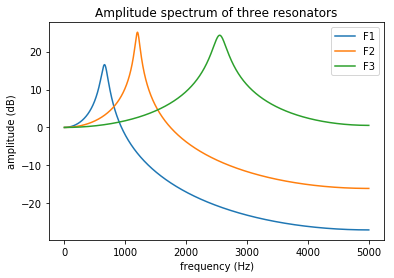

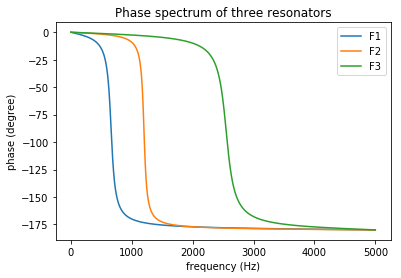

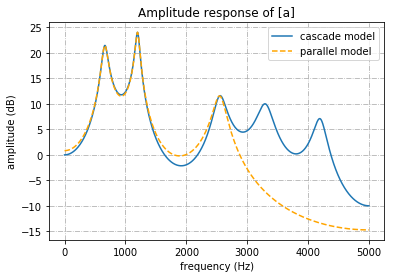

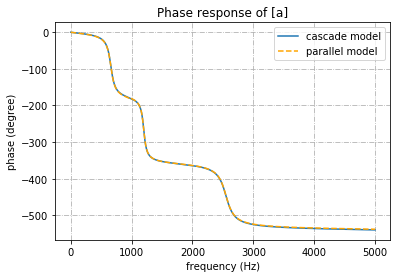

In [19]:
#a
# parallel model
f_a = [660,1200,2550]  #cutoff frequency
b_a = [100,70,200] 
gain = [1.76, 0.89,0.23]
(amp_a,pha_a) = frequency_response('a', gain, f_a, b_a)
#find maximal amplitude
F1_a = round(max(amp_a[0][100:1000]),2)
F2_a = round(max(amp_a[0][1000:2000]),2)
F3_a = round(max(amp_a[0][2000:3000]),2)
print('amplitudes of the two formant frequencies (parallel):',F1_a, 'dB', F2_a, 'dB', F3_a, 'dB')
print('unity gain of parallel model:', round(amp_a[0][0],2))

# cascade model
cas_f_a = [660,1200,2550,3300,4200]  #cutoff frequency
cas_b_a = [100,70,200,250,200] 
(cas_amp_a,cas_pha_a,cas_pha_a_3) = cascade_frequency_response('a',cas_f_a,cas_b_a)

F1_a = max(cas_amp_a[0][0:1000]) 
F2_a = max(cas_amp_a[0][1000:2000])
F3_a = max(cas_amp_a[0][2000:3000])
F4_a = max(cas_amp_a[0][3000:4000])
F5_a = max(cas_amp_a[0][4000:5000])
print(F1_a,F2_a,F3_a,F4_a,F5_a)
print('unity gain of cascade model:', round(cas_amp_a[0][0],2))

# amplitude response
f_step = 1 
f_Hz = np.arange(0,5000,f_step)
plt.figure("Amplitude response")
plt.xlabel('frequency (Hz)')
plt.ylabel('amplitude (dB)')
plt.plot(f_Hz,cas_amp_a[0], label = 'cascade model')
plt.plot(f_Hz,amp_a[0],'--', label = 'parallel model',color='orange')
plt.legend()
plt.title("Amplitude response of [a]")
plt.grid(linestyle='-.')

# phase response
plt.figure("Phase response")
plt.xlabel('frequency (Hz)')
plt.ylabel('phase (degree)')
plt.plot(f_Hz,cas_pha_a_3[0], label = 'cascade model')
plt.plot(f_Hz,pha_a[0], '--',label = 'parallel model',color='orange')
plt.legend()
plt.title("Phase response of [a]")
plt.grid(linestyle='-.')

plt.show()

amplitudes of the two formant frequencies (parallel): 16.0 dB 7.99 dB 1.75 dB
unity gain of parallel model: 0.13
15.97947170884781 7.94693175425039 2.070887439647466 -5.885248779113491 -7.34798654931609
unity gain of cascade model: 0.0


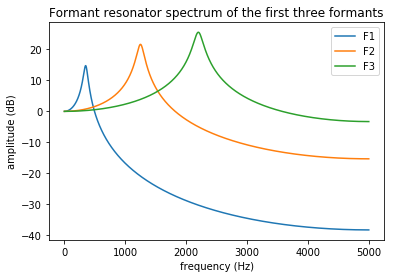

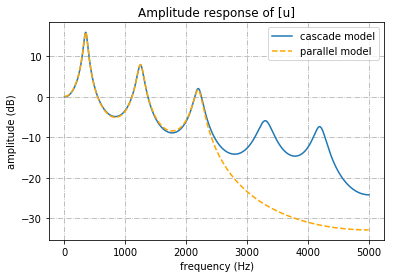

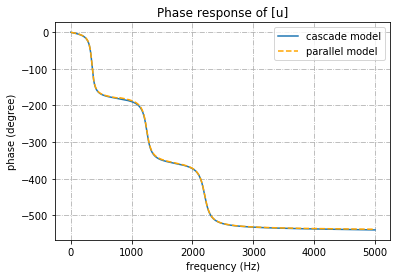

In [23]:
#u
f_u = [350,1250,2200]  #cutoff frequency
b_u = [65,110,140] #bandwidth
gain = [1.16,0.21,0.065]
(amp_u,pha_u) = frequency_response('u',gain, f_u, b_u)

#find maximal amplitude
F1_u = round(max(amp_u[0][100:1000]),2)
F2_u = round(max(amp_u[0][1000:2000]),2)
F3_u = round(max(amp_u[0][2000:3000]),2)
print('amplitudes of the two formant frequencies (parallel):',F1_u, 'dB', F2_u, 'dB', F3_u, 'dB')
print('unity gain of parallel model:', round(amp_u[0][0],2))

cas_f_u = [350,1250,2200,3300,4200]  #cutoff frequency
cas_b_u = [65,110,140,250,200] #bandwidth
(cas_amp_u,cas_pha_u,cas_pha_u_3) = cascade_frequency_response('u',cas_f_u,cas_b_u)

F1_u = max(cas_amp_u[0][0:1000]) 
F2_u = max(cas_amp_u[0][1000:2000])
F3_u = max(cas_amp_u[0][2000:3000])
F4_u = max(cas_amp_u[0][3000:4000])
F5_u = max(cas_amp_u[0][4000:5000])
print(F1_u,F2_u,F3_u,F4_u,F5_u)
print('unity gain of cascade model:', round(cas_amp_u[0][0],2))

# amplitude response
f_step = 1 
f_Hz = np.arange(0,5000,f_step)
plt.figure("Amplitude response")
plt.xlabel('frequency (Hz)')
plt.ylabel('amplitude (dB)')
plt.plot(f_Hz,cas_amp_u[0], label = 'cascade model')
plt.plot(f_Hz,amp_u[0], '--',color='orange',label = 'parallel model')
plt.legend()
plt.title("Amplitude response of [u]")
plt.grid(linestyle='-.')

# phase response
plt.figure("Phase response")
plt.xlabel('frequency (Hz)')
plt.ylabel('phase (degree)')
plt.plot(f_Hz,cas_pha_u_3[0], label = 'cascade model')
plt.plot(f_Hz,pha_u[0], '--',color='orange',label = 'parallel model')
plt.legend()
plt.title("Phase response of [u]")
plt.grid(linestyle='-.')

plt.show()

amplitudes of the two formant frequencies (parallel): 16.15 dB 16.15 dB 16.15 dB
unity gain of parallel model: 0.59
16.148632579099463 16.148632579099463 16.148632579099463 16.14863257909945 16.148632579099463
unity gain of cascade model: -0.0


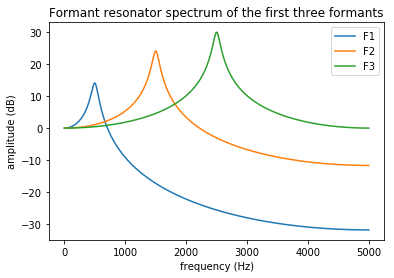

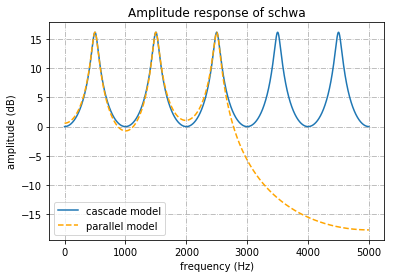

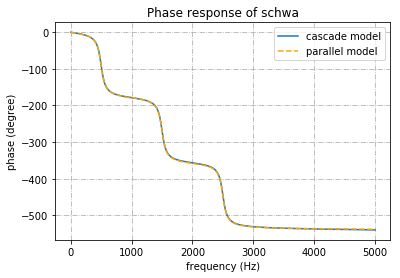

In [35]:
#schwa
f_e = [500,1500,2500]  #cutoff frequency
b_e = [100,100,100] #bandwidth
gain = [1.265,0.397,0.2017]
(amp_e,pha_e) = frequency_response('e',gain, f_e, b_e)

#find maximal amplitude
F1_e = round(max(amp_e[0][100:1000]),2)
F2_e = round(max(amp_e[0][1000:2000]),2)
F3_e = round(max(amp_e[0][2000:3000]),2)
print('amplitudes of the two formant frequencies (parallel):',F1_e, 'dB', F2_e, 'dB', F3_e, 'dB')
print('unity gain of parallel model:', round(amp_e[0][0],2))

cas_f_e = [500,1500,2500,3500,4500]  #cutoff frequency
cas_b_e = [100,100,100,100,100] #bandwidth
(cas_amp_e,cas_pha_e,cas_pha_e_3) = cascade_frequency_response('e',cas_f_e,cas_b_e)

F1_e = max(cas_amp_e[0][0:1000]) 
F2_e = max(cas_amp_e[0][1000:2000])
F3_e = max(cas_amp_e[0][2000:3000])
F4_e = max(cas_amp_e[0][3000:4000])
F5_e = max(cas_amp_e[0][4000:5000])
print(F1_e,F2_e,F3_e,F4_e,F5_e)
print('unity gain of cascade model:', round(cas_amp_e[0][0],2))

# amplitude response
f_step = 1 
f_Hz = np.arange(0,5000,f_step)
plt.figure("Amplitude response")
plt.xlabel('frequency (Hz)')
plt.ylabel('amplitude (dB)')
plt.plot(f_Hz,cas_amp_e[0], label = 'cascade model')
plt.plot(f_Hz,amp_e[0], '--',label = 'parallel model',color='orange')
plt.legend()
plt.title("Amplitude response of schwa")
plt.grid(linestyle='-.')

# phase response
plt.figure("Phase response")
plt.xlabel('frequency (Hz)')
plt.ylabel('phase (degree)')
plt.plot(f_Hz,cas_pha_e_3[0], label = 'cascade model')
plt.plot(f_Hz,pha_e[0], '--',label = 'parallel model',color='orange')
plt.legend()
plt.title("Phase response of schwa")
plt.grid(linestyle='-.')

plt.show()

amplitudes of the two formant frequencies (parallel): 20.22 dB 13.38 dB 16.16 dB
unity gain of parallel model: 0.59
32.28595174295645 32.38184570087896 19.746824385656954 20.43013932332544 20.587384036854218
unity gain of cascade model: -0.0


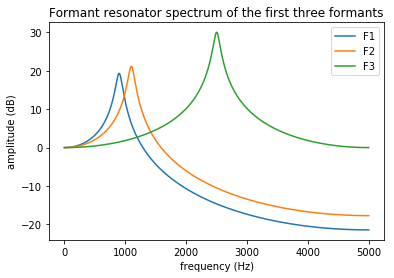

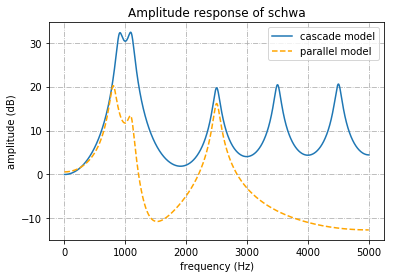

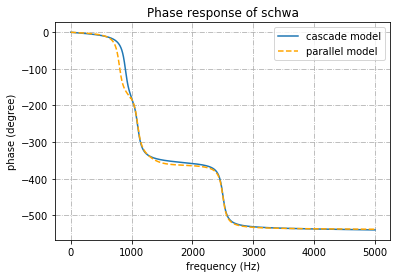

In [38]:
#schwa
f_e = [800,1100,2500]  #cutoff frequency
b_e = [100,100,100] #bandwidth
gain = [1.265,0.397,0.2017]
(amp_e,pha_e) = frequency_response('e',gain, f_e, b_e)

#find maximal amplitude
F1_e = round(max(amp_e[0][100:1000]),2)
F2_e = round(max(amp_e[0][1000:2000]),2)
F3_e = round(max(amp_e[0][2000:3000]),2)
print('amplitudes of the two formant frequencies (parallel):',F1_e, 'dB', F2_e, 'dB', F3_e, 'dB')
print('unity gain of parallel model:', round(amp_e[0][0],2))

cas_f_e = [900,1100,2500,3500,4500]  #cutoff frequency
cas_b_e = [100,100,100,100,100] #bandwidth
(cas_amp_e,cas_pha_e,cas_pha_e_3) = cascade_frequency_response('e',cas_f_e,cas_b_e)

F1_e = max(cas_amp_e[0][0:1000]) 
F2_e = max(cas_amp_e[0][1000:2000])
F3_e = max(cas_amp_e[0][2000:3000])
F4_e = max(cas_amp_e[0][3000:4000])
F5_e = max(cas_amp_e[0][4000:5000])
print(F1_e,F2_e,F3_e,F4_e,F5_e)
print('unity gain of cascade model:', round(cas_amp_e[0][0],2))

# amplitude response
f_step = 1 
f_Hz = np.arange(0,5000,f_step)
plt.figure("Amplitude response")
plt.xlabel('frequency (Hz)')
plt.ylabel('amplitude (dB)')
plt.plot(f_Hz,cas_amp_e[0], label = 'cascade model')
plt.plot(f_Hz,amp_e[0], '--',label = 'parallel model',color='orange')
plt.legend()
plt.title("Amplitude response of schwa")
plt.grid(linestyle='-.')

# phase response
plt.figure("Phase response")
plt.xlabel('frequency (Hz)')
plt.ylabel('phase (degree)')
plt.plot(f_Hz,cas_pha_e_3[0], label = 'cascade model')
plt.plot(f_Hz,pha_e[0], '--',label = 'parallel model',color='orange')
plt.legend()
plt.title("Phase response of schwa")
plt.grid(linestyle='-.')

plt.show()

# Waveform of parallel formant resonator

In [7]:
# adjust amplitude "before" each resonator

import numpy as np
import math 
import matplotlib.pyplot as plt

def difference(formant, gain, A, B, C):
    '''
    input:
    formant: int, the nth formant
    gain: list, amplitude control
    A, B, C: list, 3 coefficients
    
    output:list, amplitude value for each 1 ms
    '''
    assert type(A) == type(B) == type(C) == type(gain) == list
    output = []
    index = formant - 1
    
    #impulse_train, altogether 100 ms, an impulse / 10 ms, namely 100 Hz for f0
    imp = [0, 0, 1000]     #predefine amplitude at -2, -1, 0 ms  
    for impulse in range(100):      #10 ms/impulse
        for interval in range(99):  #1 ms = 1 sample
            imp.append(0)
        imp.append(1000)   # adjust impulse train

    for i in range(1003):
        output.append(0)
        
    for i in range(1001):  # let normal voicing go through resonator
        output[i+2] = A[index]*gain[index]*imp[i+1]+B[index]*output[i+1]+C[index]*output[i]

    return output


def waveform(name, gain, f_n, b_n):
    '''
    input: 
    name: str, vowel name
    f_n: list, cutoff frequency (F)
    b_n: list, bandwidth (BW)
    
    output: 
    waveform graph, amplitude list in linear scale
    '''
    assert type(f_n) == type(b_n) == list
    f_s = 10000                           #int, sampling frequency (Fs): 10 kHz
    t_s = 1/f_s                           #float, sampling period (Ts) = 1/sampling frequency = 0.1 ms 
    time = np.arange(-0.2,100.1,t_s*1000)      #waveform length: 100.2 ms 

    #compute sigma, omega
    sigma, omega = [], []
    for i in range(len(f_n)):
        sigma.append(-np.pi*b_n[i])
        omega.append(2*np.pi*f_n[i])
    
    #compute A,B,C
    A, B, C = [], [], []
    for i in range(len(f_n)):
        C.append(-math.exp(2*sigma[i]*t_s))
        B.append(2*math.exp(sigma[i]*t_s)*np.cos(omega[i]*t_s))
        A.append(1-B[i]-C[i])

    # first order low-pass filter               
    B.append(math.exp(-2*math.pi*100*t_s)) 
    A.append(1-B[3])
    
    #waveform of 2 formant resonators in cascade
    output_1 = difference(1, gain, A, B, C)
    output_2 = difference(2, gain, A, B, C)
    output_3 = difference(3, gain, A, B, C)
    output = []
    for i in range(len(output_1)):
        output.append(output_1[i] - output_2[i] + output_3[i])

    plt.figure("Output waveform")
    plt.xlabel('time (ms)')
    plt.ylabel('amplitude')
    plt.plot(time[2:300],output[2:300]) #from 0 ms to 1000 ms, excluding the previous 2 sequence
    plt.title("Output waveform - " + str(name))
    plt.savefig('parallel_waveform_' + str(name)+'.jpg')   
    plt.show()
    return output

# Compared to cascade waveform

In [15]:
import numpy as np
import math 
import matplotlib.pyplot as plt

def cas_difference(formant, inp, A, B, C):
    '''
    input:
    formant: int, the nth formant
    inp: list, input value
    A, B, C: list, 3 coefficients
    
    output:list, amplitude value for each 1 ms
    '''
    assert type(inp) == type(A) == type(B) == type(C) == list
    output = []
    index = formant - 1
    for i in range(1003):
        output.append(0)
    for i in range(1001):
        output[i+2] = A[index]*inp[i+1]+B[index]*output[i+1]+C[index]*output[i]
    return output

def cas_lp_filter(formant, inp, A, B, C):
    '''
    input:
    formant: int, the nth formant
    inp: list, input value
    A, B, C: list, 3 coefficients
    
    output:list, amplitude value for each 1 ms
    '''
    assert type(inp) == type(A) == type(B) == type(C) == list
    output = []
    index = formant - 1
    for i in range(1003):
        output.append(0)
    for i in range(1001):
        output[i+2] = A[index]*inp[i+2]+B[index]*output[i+1]
    return output

def cascade_waveform(name, f_n, b_n):
    '''
    input: 
    name: str, vowel name
    f_n: list, cutoff frequency (F)
    b_n: list, bandwidth (BW)
    
    output: 
    waveform graph, amplitude list in V
    '''
    assert type(f_n) == type(b_n) == list
    f_s = 10000                           #int, sampling frequency (Fs): 10 kHz
    t_s = 1/f_s                           #float, sampling period (Ts) = 1/sampling frequency = 0.1 ms 
    time = np.arange(-0.2,100.1,t_s*1000)      #waveform length: 100.2 ms 

    #compute sigma, omega
    sigma, omega = [], []
    for i in range(5):
        sigma.append(-np.pi*b_n[i])
        omega.append(2*np.pi*f_n[i])
    
    #compute A,B,C
    A, B, C = [], [], []
    for i in range(5):
        C.append(-math.exp(2*sigma[i]*t_s))
        B.append(2*math.exp(sigma[i]*t_s)*np.cos(omega[i]*t_s))
        A.append(1-B[i]-C[i])
        
    # first order low-pass filter               
    B.append(math.exp(-2*math.pi*100*t_s)) 
    A.append(1-B[5])
    
    #impulse_train, altogether 100 ms, an impulse / 10 ms, namely 100 Hz for f0
    impulse_train = [0, 0, 1000]     #predefine amplitude at -2, -1, 0 ms  
    for impulse in range(100):      #10 ms/impulse
        for interval in range(99):  #1 ms = 1 sample
            impulse_train.append(0)
        impulse_train.append(1000)   #1000/impulse
        
    plt.figure("Impulse train")
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.plot(time[2:1000],impulse_train[2:1000]) #from 0 ms to 1000 ms, excluding the previous 2 sequence
    plt.title("Simplified voicing source")
    
    #waveform of five formant resonator in cascade
    output_1 = cas_difference(1, impulse_train, A, B, C)
    output_2 = cas_difference(2, output_1, A, B, C)
    output_3 = cas_difference(3, output_2, A, B, C)
    output_4 = cas_difference(4, output_3, A, B, C)
    output_5 = cas_difference(5, output_4, A, B, C)
    
    
    plt.figure("Output waveform")
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.plot(time[2:300],output_5[2:300]) #from 0 ms to 1000 ms, excluding the previous 2 sequence
    plt.title("Output waveform - " + str(name))
    plt.savefig(str(name)+'-waveform.jpg')   
    plt.show()
    return output_5

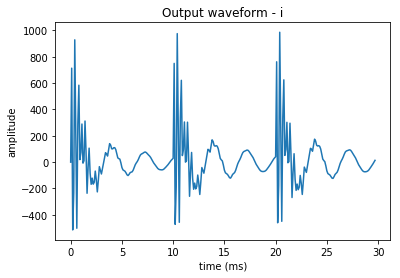

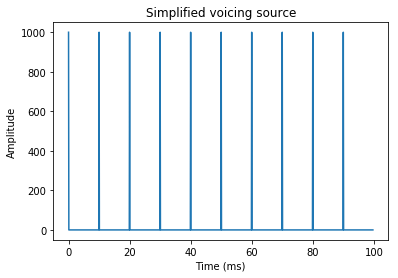

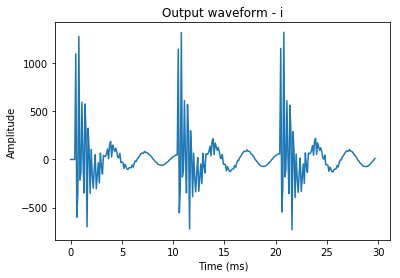

Text(0.5,1,'Output waveform of [i]')

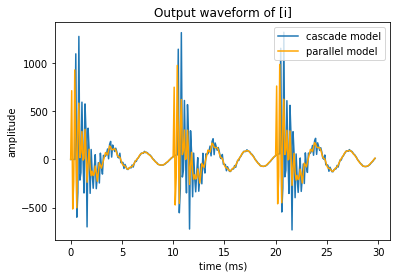

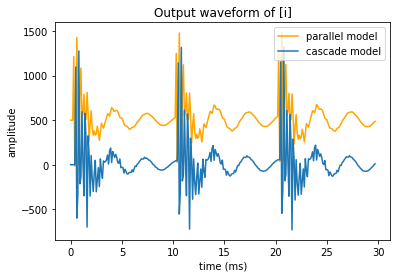

In [20]:
#i
f_s = 10000                           #int, sampling frequency (Fs): 10 kHz
t_s = 1/f_s                           #float, sampling period (Ts) = 1/sampling frequency = 0.1 ms 
time = np.arange(-0.2,100.1,t_s*1000)
    
f_i = [310,2020,2960]  # cutoff frequency
b_i = [45,200,400]    # bandwidth
gain = [1.06,0.18,0.4]  # amplitude control
output = waveform('i', gain, f_i, b_i)


cas_f_i = [310,2020,2960,3300,4200]  #cutoff frequency
cas_b_i = [45,200,400,250,200] #bandwidth
cas_output = cascade_waveform('i', cas_f_i, cas_b_i)

plt.figure("Output waveform")
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.plot(time[2:300],cas_output[2:300], label = 'cascade model')
plt.plot(time[2:300],output[2:300], label = 'parallel model',color='orange') #from 0 ms to 1000 ms, excluding the previous 2 sequence
plt.legend(loc='upper right')
plt.title("Output waveform of [i]")

modified_output = []
for i in range(len(output[2:300])):
    modified_output.append(output[i]+500)
    
plt.figure("Modified output waveform")
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.plot(time[2:300],modified_output[0:298], label = 'parallel model',color='orange') #from 0 ms to 1000 ms, excluding the previous 2 sequence
plt.plot(time[2:300],cas_output[2:300], label = 'cascade model')
plt.legend(loc='upper right')
plt.title("Output waveform of [i]")

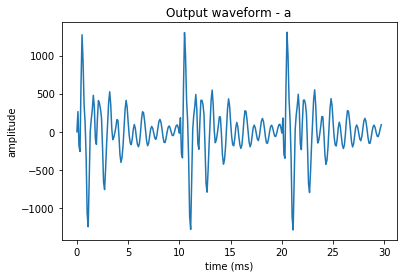

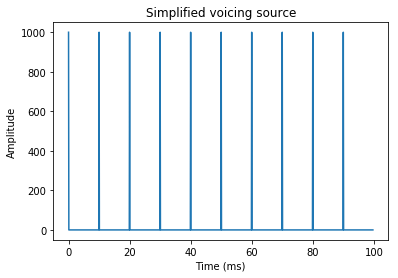

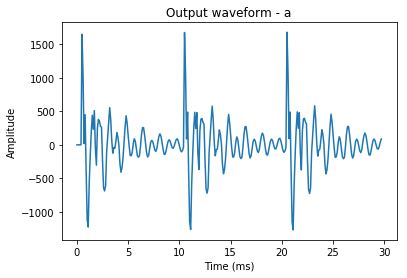

Text(0.5,1,'Output waveform of [a]')

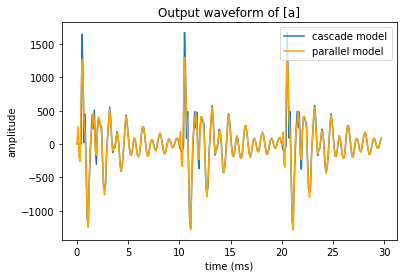

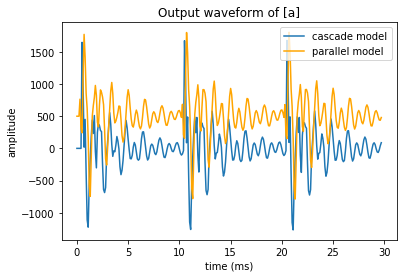

In [19]:
#a
f_a = [660,1200,2550]  #cutoff frequency
b_a = [100,70,200] 
gain = [1.76, 0.89,0.23]
output = waveform('a', gain, f_a, b_a)

cas_f_a = [660,1200,2550,3300,4200]  #cutoff frequency
cas_b_a = [100,70,200,250,200] 
cas_output = cascade_waveform('a', cas_f_a, cas_b_a)

f_s = 10000                           #int, sampling frequency (Fs): 10 kHz
t_s = 1/f_s                           #float, sampling period (Ts) = 1/sampling frequency = 0.1 ms 
time = np.arange(-0.2,100.1,t_s*1000)
plt.figure("Output waveform")
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.plot(time[2:300],cas_output[2:300], label = 'cascade model')
plt.plot(time[2:300],output[2:300], label = 'parallel model',color='orange') #from 0 ms to 1000 ms, excluding the previous 2 sequence
plt.legend()
plt.title("Output waveform of [a]")

modified_output = []
for i in range(len(output[2:300])):
    modified_output.append(output[i]+500)
    
plt.figure("Modified output waveform")
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.plot(time[2:300],cas_output[2:300], label = 'cascade model')
plt.plot(time[2:300],modified_output[0:298], label = 'parallel model',color='orange') #from 0 ms to 1000 ms, excluding the previous 2 sequence
plt.legend(loc='upper right')
plt.title("Output waveform of [a]")

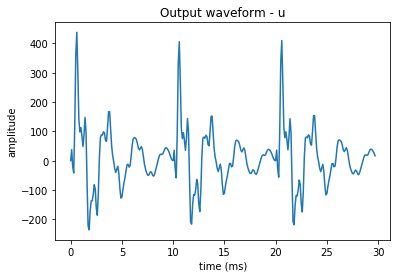

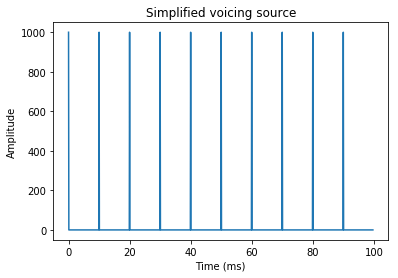

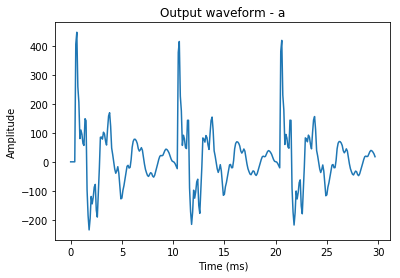

Text(0.5,1,'Output waveform of [u]')

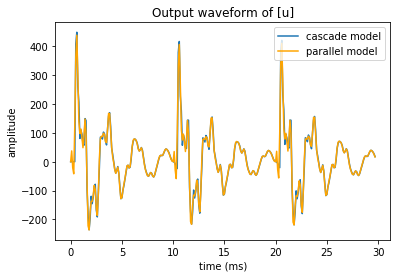

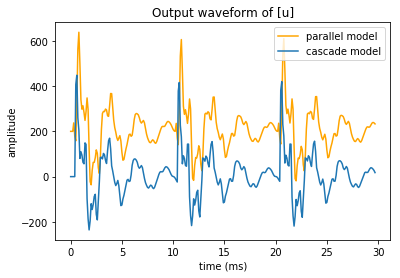

In [17]:
# u
f_u = [350,1250,2200]  #cutoff frequency
b_u = [65,110,140] #bandwidth
gain = [1.16,0.21,0.065]
output = waveform('u', gain, f_u, b_u)

cas_f_u = [350,1250,2200,3300,4200]  #cutoff frequency
cas_b_u = [65,110,140,250,200] #bandwidth
cas_output = cascade_waveform('a', cas_f_u, cas_b_u)

f_s = 10000                           #int, sampling frequency (Fs): 10 kHz
t_s = 1/f_s                           #float, sampling period (Ts) = 1/sampling frequency = 0.1 ms 
time = np.arange(-0.2,100.1,t_s*1000)
plt.figure("Output waveform")
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.plot(time[2:300],cas_output[2:300], label = 'cascade model')
plt.plot(time[2:300],output[2:300], label = 'parallel model',color='orange') #from 0 ms to 1000 ms, excluding the previous 2 sequence
plt.legend()
plt.title("Output waveform of [u]")

modified_output = []
for i in range(len(output[2:300])):
    modified_output.append(output[i]+200)
    
plt.figure("Modified output waveform")
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.plot(time[2:300],modified_output[0:298], label = 'parallel model',color='orange') #from 0 ms to 1000 ms, excluding the previous 2 sequence
plt.plot(time[2:300],cas_output[2:300], label = 'cascade model')
plt.legend()
plt.title("Output waveform of [u]")

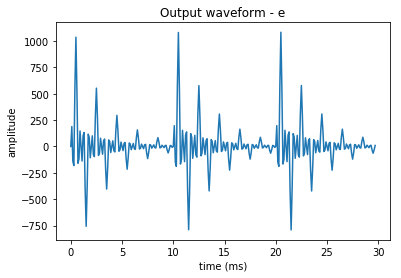

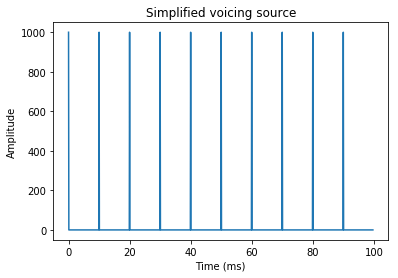

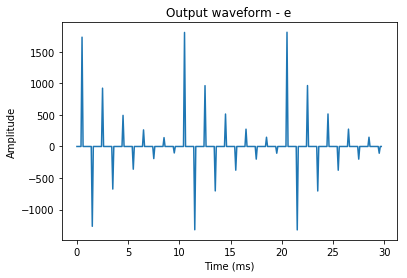

Text(0.5,1,'Output waveform of schwa')

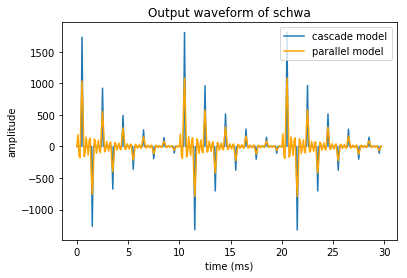

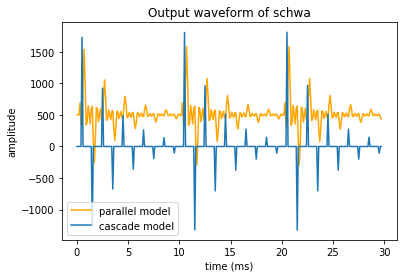

In [21]:
# schwa
f_e = [500,1500,2500]  #cutoff frequency
b_e = [100,100,100] #bandwidth
gain = [1.265,0.4,0.2]
output = waveform('e', gain, f_e, b_e)

cas_f_e = [500,1500,2500,3500,4500]  #cutoff frequency
cas_b_e = [100,100,100,100,100] #bandwidth
cas_output = cascade_waveform('e', cas_f_e, cas_b_e)

f_s = 10000                           #int, sampling frequency (Fs): 10 kHz
t_s = 1/f_s                           #float, sampling period (Ts) = 1/sampling frequency = 0.1 ms 
time = np.arange(-0.2,100.1,t_s*1000)
plt.figure("Output waveform")
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.plot(time[2:300],cas_output[2:300], label = 'cascade model')
plt.plot(time[2:300],output[2:300], label = 'parallel model',color='orange') #from 0 ms to 1000 ms, excluding the previous 2 sequence
plt.legend()
plt.title("Output waveform of schwa")

modified_output = []
for i in range(len(output[2:300])):
    modified_output.append(output[i]+500)
    
plt.figure("Modified output waveform")
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.plot(time[2:300],modified_output[0:298], label = 'parallel model',color='orange') #from 0 ms to 1000 ms, excluding the previous 2 sequence
plt.plot(time[2:300],cas_output[2:300], label = 'cascade model')
plt.legend()
plt.title("Output waveform of schwa")